## Get extrinsic params using robust calibration paper
Output: R, T between camera pairs

In [5]:
import sys

if '/Users/damianstone/Documents/Code/tennis-project/post-triangulation/' not in sys.path:
  sys.path.append('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/')

In [6]:
import cv2 as cv
import numpy as np
import glob
import json

BASE_PATH = '/Users/damianstone/Documents/Code/tennis-project/post-triangulation/'
IMAGE_BASE_PATH = f'{BASE_PATH}/images/'
INTRINSIC_PARAMS_FILE_NAME = 'intrinsic_params.json'

STEREO_PAIRS = {
    "STEREO_1": ("left_stereo_1/*.png", "right_stereo_1/*.png"),  # CAM_1 & CAM_2
    "STEREO_2": ("left_stereo_2/*.png", "right_stereo_2/*.png")   # CAM_3 & CAM_4
}

In [7]:
# load intrinsic parameters
with open(f'{BASE_PATH}/data/{INTRINSIC_PARAMS_FILE_NAME}', "r") as file:
    camera_data = json.load(file)

camera_data

{'CAM_1_LEFT': {'fx': 1800.0,
  'fy': 1805.0,
  'cx': 1920.0,
  'cy': 1080.0,
  'D': [-0.25, 0.05, 0.0, 0.0, -0.02],
  'K': [[1800.0, 0, 1920.0], [0, 1805.0, 1080.0], [0, 0, 1]]},
 'CAM_2_RIGHT': {'fx': 1795.0,
  'fy': 1800.0,
  'cx': 1918.0,
  'cy': 1078.0,
  'D': [-0.23, 0.04, 0.0, 0.0, -0.015],
  'K': [[1795.0, 0, 1918.0], [0, 1800.0, 1078.0], [0, 0, 1]]},
 'CAM_3_LEFT': {'fx': 1810.0,
  'fy': 1812.0,
  'cx': 1925.0,
  'cy': 1082.0,
  'D': [-0.27, 0.06, 0.0, 0.0, -0.018],
  'K': [[1810.0, 0, 1925.0], [0, 1812.0, 1082.0], [0, 0, 1]]},
 'CAM_4_RIGHT': {'fx': 1805.0,
  'fy': 1810.0,
  'cx': 1922.0,
  'cy': 1081.0,
  'D': [-0.24, 0.05, 0.0, 0.0, -0.017],
  'K': [[1805.0, 0, 1922.0], [0, 1810.0, 1081.0], [0, 0, 1]]}}

In [28]:
import cv2 as cv
import numpy as np

# --- Main functions implementing the paper’s steps ---

def white_pixel_detector_temp(image, sigma_l=128, sigma_d=20, tau=8):
    """
    Implements Section 3.1: Detect white court-line pixels.
    (Use brightness and neighbor tests; here a simplified version.)
    """
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Simple threshold-based candidate selection (placeholder)
    mask = (gray >= sigma_l).astype(np.uint8) * 255
    return mask

def hough_line_detection_temp(white_mask, threshold=100, min_line_length=50, max_line_gap=5):
    """
    Section 3.2.1: Extract candidate court lines using Hough transform.
    """
    lines = cv.HoughLinesP(white_mask, 1, np.pi/180, threshold,
                           minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

def refine_lines(candidate_lines):
    """
    Section 3.2.2: Refine line parameters using least squares fitting on nearby white pixels.
    (Placeholder: return candidate_lines as-is.)
    """
    return candidate_lines

def court_model_fitting(refined_lines, court_model):
    """
    Section 3.3: Combinatorial search to assign candidate lines to the court model.
    Computes intersection points and solves a linear system to estimate the 8-parameter homography H.
    (Placeholder: returns an identity matrix.)
    """
    H = np.eye(3)
    return H

def calibration_rejection_test(H):
    """
    Section 3.3.2: Quickly reject physically impossible solutions using non-isotropic scaling test.
    (Placeholder: always accepts.)
    """
    return True

def evaluate_model_support(H, white_mask, court_model):
    """
    Section 3.3.3: Project the court model with H, sample along model lines, and compute a matching score.
    (Placeholder: returns a dummy score.)
    """
    score = 1.0
    return score

def calibrate_camera(image, court_model):
    """
    Full calibration for one camera on a single frame:
      - Detect white pixels
      - Extract & refine line candidates
      - Perform model fitting via combinatorial search
      - Reject and evaluate candidate H, and return the best H.
    """
    white_mask = white_pixel_detector(image)
    candidate_lines = hough_line_detection(white_mask)
    refined_lines = refine_lines(candidate_lines)
    H = court_model_fitting(refined_lines, court_model)
    if calibration_rejection_test(H):
        score = evaluate_model_support(H, white_mask, court_model)
        # In a full implementation, search over multiple assignments and choose the best H.
        return H  # Placeholder: return H directly
    return None

def stereo_extrinsics_from_homographies(H_left, H_right):
    """
    Compute the relative transformation between two cameras from their estimated homographies.
    A simple approach: H_rel = H_right * inv(H_left)
    (Further decomposition into R and T can be done if needed.)
    """
    H_rel = H_right @ np.linalg.inv(H_left)
    return H_rel

def calibrate_stereo_pair(images_left, images_right, court_model):
    """
    Calibrate a stereo pair by processing multiple frames:
      - For each camera, run the single-camera calibration (using the court model) over several frames.
      - For simplicity, select the first successful H from each camera.
      - Compute the relative extrinsics.
    """
    H_left, H_right = None, None
    for img_l, img_r in zip(images_left, images_right):
        H_l = calibrate_camera(img_l, court_model)
        H_r = calibrate_camera(img_r, court_model)
        if H_l is not None and H_r is not None:
            H_left, H_right = H_l, H_r
            break
    if H_left is None or H_right is None:
        return None
    H_rel = stereo_extrinsics_from_homographies(H_left, H_right)
    return H_left, H_right, H_rel

def calibrate_four_cameras(images_left1, images_right1, images_left2, images_right2, court_model):
    """
    Adapted for 4 cameras (two stereo pairs):
      - Calibrate stereo pair 1 (e.g., left side of court): CAM_1 & CAM_2.
      - Calibrate stereo pair 2 (e.g., right side of court): CAM_3 & CAM_4.
    """
    H_left1, H_right1, H_rel1 = calibrate_stereo_pair(images_left1, images_right1, court_model)
    H_left2, H_right2, H_rel2 = calibrate_stereo_pair(images_left2, images_right2, court_model)
    return {
        "Stereo_Pair_1": {"H_left": H_left1, "H_right": H_right1, "H_rel": H_rel1},
        "Stereo_Pair_2": {"H_left": H_left2, "H_right": H_right2, "H_rel": H_rel2}
    }
    
    

def pipeline(folder_left1, folder_right1, folder_left2, folder_right2, court_model, intrinsics):
    """
    Calibrates four cameras (two stereo pairs) using the court model.
    
    Parameters:
      folder_left1, folder_right1: paths for stereo pair 1 (e.g., CAM_1 and CAM_2)
      folder_left2, folder_right2: paths for stereo pair 2 (e.g., CAM_3 and CAM_4)
      court_model: the predefined court model (real-world line positions)
      intrinsics: a dictionary with keys "CAM_1", "CAM_2", "CAM_3", "CAM_4". Each entry should contain:
                  "K": the intrinsic matrix (3x3) and
                  "D": the distortion coefficients (unused here).
    
    Returns:
      A dictionary containing for each stereo pair:
         - P_left: projection matrix for the left camera (K_left * [I|0])
         - P_right: projection matrix for the right camera (K_right * [R|T])
         - R: rotation matrix between the pair
         - T: translation vector between the pair
    """
    images_left1 = sorted(glob.glob(f"{folder_left1}/*.png"))
    images_right1 = sorted(glob.glob(f"{folder_right1}/*.png"))
    images_left2 = sorted(glob.glob(f"{folder_left2}/*.png"))
    images_right2 = sorted(glob.glob(f"{folder_right2}/*.png"))
    
    # Calibrate stereo pair 1 (CAM_1 and CAM_2)
    R1, T1 = calibrate_stereo_pair(images_left1, images_right1, court_model,
                                   intrinsics["CAM_1"], intrinsics["CAM_2"])
    # Calibrate stereo pair 2 (CAM_3 and CAM_4)
    R2, T2 = calibrate_stereo_pair(images_left2, images_right2, court_model,
                                   intrinsics["CAM_3"], intrinsics["CAM_4"])
    
    # Compute projection matrices: P = K * [R|T]
    # For left cameras, we assume identity rotation and zero translation.
    P_left1 = intrinsics["CAM_1"]["K"] @ np.hstack((np.eye(3), np.zeros((3,1))))
    P_right1 = intrinsics["CAM_2"]["K"] @ np.hstack((R1, T1))
    
    P_left2 = intrinsics["CAM_3"]["K"] @ np.hstack((np.eye(3), np.zeros((3,1))))
    P_right2 = intrinsics["CAM_4"]["K"] @ np.hstack((R2, T2))
    
    results = {
        "Stereo_Pair_1": {
            "P_left": P_left1,
            "P_right": P_right1,
            "R": R1,
            "T": T1
        },
        "Stereo_Pair_2": {
            "P_left": P_left2,
            "P_right": P_right2,
            "R": R2,
            "T": T2
        }
    }
    return results


In [4]:
import matplotlib.pyplot as plt

def print_image(imread_img):
  img = cv.cvtColor(imread_img, cv.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### White pixel detector

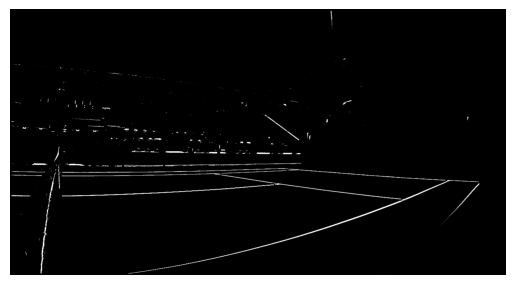

In [31]:

def white_pixel_detector(img, tau=8, thresh_l=128, thresh_d=15, block_size=20, aperture_size=3):
    """
    Simplified white pixel detection for court lines (Section 3.1).
    
    Parameters:
      img: BGR image.
      tau: pixel offset for neighbor comparisons.
      thresh_l: luminance threshold.
      thresh_d: minimum brightness difference.
      block_size: window size for structure tensor.
      aperture_size: aperture for computing gradients.
    
    Returns:
      combined_mask: an 8-bit image where white pixels (255) are potential court-line pixels.
    """
    # Convert to YCbCr and extract the Y (luminance) channel.
    img_ycbcr = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    y_channel = img_ycbcr[:, :, 0].astype(np.int32)
    height, width = y_channel.shape

    # Initialize candidate mask.
    candidate_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Avoid boundaries by processing only the central region.
    central = y_channel[tau:-tau, tau:-tau]
    left_neighbors = y_channel[tau:-tau, 0:width-2*tau]
    right_neighbors = y_channel[tau:-tau, 2*tau:width]
    top_neighbors = y_channel[0:height-2*tau, tau:-tau]
    bottom_neighbors = y_channel[2*tau:height, tau:-tau]
    
    # Condition for horizontal white pixel detection.
    cond_h = (central >= thresh_l) & ((central - left_neighbors) > thresh_d) & ((central - right_neighbors) > thresh_d)
    
    # Condition for vertical white pixel detection.
    cond_v = (central >= thresh_l) & ((central - top_neighbors) > thresh_d) & ((central - bottom_neighbors) > thresh_d)
    candidate = ((cond_h | cond_v).astype(np.uint8)) * 255
    candidate_mask[tau:-tau, tau:-tau] = candidate

    # Compute the structure tensor (corner eigenvalues) on the Y channel.
    img_y_float = img_ycbcr[:, :, 0].astype(np.float32)
    structure = cv.cornerEigenValsAndVecs(img_y_float, block_size, aperture_size)
    
    # The first two channels are eigenvalues.
    ev0 = structure[:, :, 0]
    ev1 = structure[:, :, 1]
    max_ev = np.maximum(ev0, ev1)
    min_ev = np.minimum(ev0, ev1)
    
    # Structure constraint: mark pixels with dominant orientation (line-like) if max eigenvalue > 4 * min eigenvalue.
    structure_mask = ((max_ev > 4 * min_ev).astype(np.uint8)) * 255

    # Combine the candidate mask with the structure mask.
    combined_mask = cv.bitwise_and(candidate_mask, candidate_mask, mask=structure_mask)
    
    return combined_mask

  

white_pixel_img = cv.imread(f'{IMAGE_BASE_PATH}/side-view/side-1.jpg')
# print_image(white_pixel_img)
processed = white_pixel_detector(white_pixel_img)
print_image(processed)


### Hough transform

In [ ]:
def hough_line_detection(white_mask, threshold=100, min_line_length=50, max_line_gap=5):
    """
    Section 3.2.1: Extract candidate court lines using Hough transform.
    """
    lines = cv.HoughLinesP(white_mask, 1, np.pi/180, threshold,
                           minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines
  
hough_img = cv.imread(f'{IMAGE_BASE_PATH}/side-view/side-1.jpg')
hough_mask = white_pixel_detector(hough_img)
lines = hough_line_detection_temp(hough_mask)
print_image(lines)